# Direct forecasting

[Forecasting with Machine Learning - Course](https://www.trainindata.com/p/forecasting-with-machine-learning)

Load the retail sales data set located in Facebook's Prophet Github repository and use **direct forecasting** to predict future sales. 

- We want to forecast sales over the next 3 months. 
- Sales are recorded monthly. 
- We assume that we have all data to the month before the first point in the forecasting horizon.

We will forecast using Scikit-learn in this exercise.

Follow the guidelines below to accomplish this assignment.

## Import required classes and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler

from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)
from feature_engine.pipeline import Pipeline

## Load data

In [2]:
url = "https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv"
df = pd.read_csv(url)
df.to_csv("example_retail_sales.csv", index=False)

df = pd.read_csv(
    "example_retail_sales.csv",
    parse_dates=["ds"],
    index_col=["ds"],
    nrows=160,
)

df = df.asfreq("MS")

df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


## Create the target variable

In direct forecasting, we train a model per step. Hence, we need to create 1 target per step.

In [3]:
horizon = 3
y = pd.DataFrame(index=df.index)
for step in range(horizon):
    y[f"h_{step}"] = df["y"].shift(-step)
y

,h_0,h_1,h_2
ds,,,
1992-01-01,146376,147079.0,159336.0
1992-02-01,147079,159336.0,163669.0
1992-03-01,159336,163669.0,170068.0
1992-04-01,163669,170068.0,168663.0
1992-05-01,170068,168663.0,169890.0
...,...,...,...
2004-12-01,387155,293261.0,295062.0
2005-01-01,293261,295062.0,339141.0
2005-02-01,295062,339141.0,335632.0


In [4]:
y.dropna(inplace=True)
df = df.loc[y.index]
df.tail()

,y
ds,
2004-10-01,319726
2004-11-01,324259
2004-12-01,387155
2005-01-01,293261
2005-02-01,295062


## Split data into train and test

Leave data from 2004 onwards in the test set.

In [5]:
end_train = "2003-12-31"
X_train = df.loc[:end_train]
y_train = y.loc[:end_train]
# We need as many data points as the
# biggest lag.

# For a lag of 12:
begin_test = "2003-01-01"
X_test = df.loc[begin_test:]
y_test = y.loc[begin_test:]

## Set up regression model

We will use Lasso in this assignment.

In [6]:
# Lasso

lasso = MultiOutputRegressor(Lasso(random_state=0))

## Set up a feature engineering pipeline

Set up transformers from feature-engine and / or scikit- learn in a pipeline and test it to make sure the input feature table is the one you need for the forecasts.

We will use feature-engine because we are great fans of the library.

If you prefer pandas, as long as the input feature table is the one you expect, that is also a suitable alternative.

In [7]:
# Lag features.

lagf = LagFeatures(
    variables=["y"],  # the input variables
    periods=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],  # 12 lags
    missing_values="ignore",
)

# test
lagf.fit_transform(X_train)

,y,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8,y_lag_9,y_lag_10,y_lag_11,y_lag_12
ds,,,,,,,,,,,,,
1992-01-01,146376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-02-01,147079,146376.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-03-01,159336,147079.0,146376.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-04-01,163669,159336.0,147079.0,146376.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-05-01,170068,163669.0,159336.0,147079.0,146376.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003-08-01,317056,309923.0,300998.0,312389.0,294251.0,293693.0,259051.0,268328.0,337006.0,290705.0,287540.0,273189.0,307256.0
2003-09-01,293890,317056.0,309923.0,300998.0,312389.0,294251.0,293693.0,259051.0,268328.0,337006.0,290705.0,287540.0,273189.0
2003-10-01,304036,293890.0,317056.0,309923.0,300998.0,312389.0,294251.0,293693.0,259051.0,268328.0,337006.0,290705.0,287540.0


In [8]:
# window features

winf = WindowFeatures(
    variables=["y"],  # the input variable
    window=[3, 6, 12],  # window size
    periods=1,  # move 1 month forward
    functions=["mean", "std"],
    missing_values="ignore",
    drop_original=True,  # drop demand when i don't need it any more
)

# test
winf.fit_transform(X_train)

,y_window_3_mean,y_window_3_std,y_window_6_mean,y_window_6_std,y_window_12_mean,y_window_12_std
ds,,,,,,
1992-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1992-02-01,NaN,NaN,NaN,NaN,NaN,NaN
1992-03-01,NaN,NaN,NaN,NaN,NaN,NaN
1992-04-01,150930.333333,7288.002218,NaN,NaN,NaN,NaN
1992-05-01,156694.666667,8604.621220,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2003-08-01,307770.000000,5992.935591,295050.833333,19264.649495,294527.416667,21381.590610
2003-09-01,309325.666667,8045.647664,304718.333333,9829.645195,295344.083333,22087.457335
2003-10-01,306956.333333,11864.515259,304751.166667,9785.683245,297069.166667,20980.443660


In [9]:
datetime_f = DatetimeFeatures(
    variables="index",
    features_to_extract=["month", "day_of_week"],
    drop_original=True,
)

datetime_f.fit_transform(X_train)

,y,month,day_of_week
ds,,,
1992-01-01,146376,1,2
1992-02-01,147079,2,5
1992-03-01,159336,3,6
1992-04-01,163669,4,2
1992-05-01,170068,5,4
...,...,...,...
2003-08-01,317056,8,4
2003-09-01,293890,9,0
2003-10-01,304036,10,2


## Test pipeline over test set

Ensure that the returned input feature table is suitable to forecast from `2004-01-01` onwards.

In [10]:
# test transformation pipeline

pipe = Pipeline(
    [
        ("dt", datetime_f),
        ("lagf", lagf),
        ("winf", winf),
        ("dropna", DropMissingData()),
        ("scaler", MinMaxScaler()),
    ]
).set_output(transform="pandas")

pipe.fit(X_train, y_train)

Pipeline(steps=[('dt',
                 DatetimeFeatures(features_to_extract=['month', 'day_of_week'],
                                  variables='index')),
                ('lagf',
                 LagFeatures(missing_values='ignore',
                             periods=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                             variables=['y'])),
                ('winf',
                 WindowFeatures(drop_original=True, functions=['mean', 'std'],
                                missing_values='ignore', variables=['y'],
                                window=[3, 6, 12])),
                ('dropna', DropMissingData()), ('scaler', MinMaxScaler())])

In [11]:
# the data that will be used for training
# or for predictions later on:

Xt = pipe.transform(X_train)

Xt.head()

,month,day_of_week,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8,y_lag_9,y_lag_10,y_lag_11,y_lag_12,y_window_3_mean,y_window_3_std,y_window_6_mean,y_window_6_std,y_window_12_mean,y_window_12_std
ds,,,,,,,,,,,,,,,,,,,,
1993-01-01,0.000000,0.666667,0.314313,0.114809,0.126087,0.077734,0.108480,0.105944,0.099380,0.106897,0.072662,0.049481,0.000000,0.000000,0.176767,0.474567,0.054520,0.527507,0.000000,0.135111
1993-02-01,0.090909,0.000000,0.016767,0.314313,0.114809,0.126087,0.077734,0.108480,0.105944,0.099380,0.106897,0.072662,0.064535,0.003688,0.131781,0.647640,0.034298,0.626264,0.004338,0.064022
1993-03-01,0.181818,0.000000,0.000000,0.016767,0.314313,0.114809,0.126087,0.077734,0.108480,0.105944,0.099380,0.106897,0.087349,0.067985,0.084536,0.757885,0.009700,0.717775,0.006245,0.028742
1993-04-01,0.272727,0.500000,0.108881,0.000000,0.016767,0.314313,0.114809,0.126087,0.077734,0.108480,0.105944,0.099380,0.121041,0.090715,0.000000,0.240742,0.016763,0.710842,0.013282,0.000454
1993-05-01,0.363636,0.833333,0.141072,0.108881,0.000000,0.016767,0.314313,0.114809,0.126087,0.077734,0.108480,0.105944,0.113644,0.124283,0.051152,0.307696,0.020161,0.714429,0.021386,0.000000


In [12]:
Xt.tail()

,month,day_of_week,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8,y_lag_9,y_lag_10,y_lag_11,y_lag_12,y_window_3_mean,y_window_3_std,y_window_6_mean,y_window_6_std,y_window_12_mean,y_window_12_std
ds,,,,,,,,,,,,,,,,,,,,
2003-08-01,0.636364,0.666667,0.855108,0.807360,0.868301,0.771265,0.768279,0.582948,0.632579,1.000000,0.752294,0.735361,0.663992,0.843939,0.989725,0.124525,0.917524,0.646998,0.963520,0.673597
2003-09-01,0.727273,0.000000,0.893269,0.855108,0.807360,0.868301,0.771265,0.768279,0.582948,0.632579,1.000000,0.752294,0.739553,0.665231,1.000000,0.172572,0.987891,0.287318,0.969732,0.741360
2003-10-01,0.818182,0.333333,0.769333,0.893269,0.855108,0.807360,0.868301,0.771265,0.768279,0.582948,0.632579,1.000000,0.756217,0.740513,0.984352,0.261957,0.988130,0.285642,0.982852,0.635087
2003-11-01,0.909091,0.833333,0.823613,0.769333,0.893269,0.855108,0.807360,0.868301,0.771265,0.768279,0.582948,0.632579,1.000000,0.757116,0.971391,0.256062,1.000000,0.232952,0.993307,0.621534
2003-12-01,1.000000,0.000000,0.808789,0.823613,0.769333,0.893269,0.855108,0.807360,0.868301,0.771265,0.768279,0.582948,0.638398,1.000000,0.936627,0.107001,0.986505,0.218792,1.000000,0.608672


In [13]:
# we can also obtain the aligned target if
# we wanted with feature-engine's pipeline:

Xt, yt = pipe.transform_x_y(X_train, y_train)

In [14]:
Xt.head()

,month,day_of_week,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8,y_lag_9,y_lag_10,y_lag_11,y_lag_12,y_window_3_mean,y_window_3_std,y_window_6_mean,y_window_6_std,y_window_12_mean,y_window_12_std
ds,,,,,,,,,,,,,,,,,,,,
1993-01-01,0.000000,0.666667,0.314313,0.114809,0.126087,0.077734,0.108480,0.105944,0.099380,0.106897,0.072662,0.049481,0.000000,0.000000,0.176767,0.474567,0.054520,0.527507,0.000000,0.135111
1993-02-01,0.090909,0.000000,0.016767,0.314313,0.114809,0.126087,0.077734,0.108480,0.105944,0.099380,0.106897,0.072662,0.064535,0.003688,0.131781,0.647640,0.034298,0.626264,0.004338,0.064022
1993-03-01,0.181818,0.000000,0.000000,0.016767,0.314313,0.114809,0.126087,0.077734,0.108480,0.105944,0.099380,0.106897,0.087349,0.067985,0.084536,0.757885,0.009700,0.717775,0.006245,0.028742
1993-04-01,0.272727,0.500000,0.108881,0.000000,0.016767,0.314313,0.114809,0.126087,0.077734,0.108480,0.105944,0.099380,0.121041,0.090715,0.000000,0.240742,0.016763,0.710842,0.013282,0.000454
1993-05-01,0.363636,0.833333,0.141072,0.108881,0.000000,0.016767,0.314313,0.114809,0.126087,0.077734,0.108480,0.105944,0.113644,0.124283,0.051152,0.307696,0.020161,0.714429,0.021386,0.000000


In [15]:
yt.head()

,h_0,h_1,h_2
ds,,,
1993-01-01,153221,150087.0,170439.0
1993-02-01,150087,170439.0,176456.0
1993-03-01,170439,176456.0,182231.0
1993-04-01,176456,182231.0,181535.0
1993-05-01,182231,181535.0,183682.0


In [16]:
Xt.shape, yt.shape

((132, 20), (132, 3))

In [17]:
X_train.shape, y_train.shape

((144, 1), (144, 3))

## Test pipeline over test set

Ensure that the returned input feature table is suitable to forecast from `2004-01-01` onwards.

In [18]:
Xt, yt = pipe.transform_x_y(X_test, y_test)

Xt.head()

,month,day_of_week,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8,y_lag_9,y_lag_10,y_lag_11,y_lag_12,y_window_3_mean,y_window_3_std,y_window_6_mean,y_window_6_std,y_window_12_mean,y_window_12_std
ds,,,,,,,,,,,,,,,,,,,,
2004-01-01,0.000000,0.500000,1.110053,0.808789,0.823613,0.769333,0.893269,0.855108,0.807360,0.868301,0.771265,0.768279,0.589553,0.639731,1.076836,0.727216,1.055142,0.780363,1.013038,0.982077
2004-02-01,0.090909,1.000000,0.702834,1.110053,0.808789,0.823613,0.769333,0.893269,0.855108,0.807360,0.868301,0.771265,0.771949,0.591066,1.027134,0.908581,1.020613,0.920567,1.021361,0.854242
2004-03-01,0.181818,0.000000,0.708098,0.702834,1.110053,0.808789,0.823613,0.769333,0.893269,0.855108,0.807360,0.868301,0.774887,0.772790,0.985699,1.006284,0.978625,0.984226,1.036187,0.549461
2004-04-01,0.272727,0.500000,0.904081,0.708098,0.702834,1.110053,0.808789,0.823613,0.769333,0.893269,0.855108,0.807360,0.870387,0.775717,0.900940,0.486078,1.009180,0.990623,1.052276,0.563147
2004-05-01,0.363636,0.833333,0.883292,0.904081,0.708098,0.702834,1.110053,0.808789,0.823613,0.769333,0.893269,0.855108,0.810411,0.870865,0.975200,0.455241,1.022712,0.993749,1.065548,0.541814


As you see, the first point in the test set is `2004-01-01` which is the point we want to forecast first.

All previous points, which we needed to create the lags, were removed.

## Train a recursive forecaster

Now that we know that the pipeline works, we can train the forecaster.

You can take the feature table and target returned up to here to train the Lasso. 

Or, as we will do, you can add the Lasso within the pipeline.

In [19]:
# set up full pipeline

pipe = Pipeline(
    [
        ("dt", datetime_f),
        ("lagf", lagf),
        ("winf", winf),
        ("dropna", DropMissingData()),
        ("scaler", MinMaxScaler()),
        ("lasso", lasso),
    ]
).set_output(transform="pandas")

pipe.fit(X_train, y_train)

/Users/z004nn0s/Library/Caches/virtualenvs/forecasting-with-machine-learning-bwwiQXoW-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.452e+08, tolerance: 2.564e+07
  model = cd_fast.enet_coordinate_descent(
/Users/z004nn0s/Library/Caches/virtualenvs/forecasting-with-machine-learning-bwwiQXoW-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.026e+08, tolerance: 2.500e+07
  model = cd_fast.enet_coordinate_descent(
/Users/z004nn0s/Library/Caches/virtualenvs/forecasting-with-machine-learning-bwwiQXoW-py3.12/lib/python3.12/site-packages/sklearn/linear_m

Pipeline(steps=[('dt',
                 DatetimeFeatures(features_to_extract=['month', 'day_of_week'],
                                  variables='index')),
                ('lagf',
                 LagFeatures(missing_values='ignore',
                             periods=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                             variables=['y'])),
                ('winf',
                 WindowFeatures(drop_original=True, functions=['mean', 'std'],
                                missing_values='ignore', variables=['y'],
                                window=[3, 6, 12])),
                ('dropna', DropMissingData()), ('scaler', MinMaxScaler()),
                ('lasso',
                 MultiOutputRegressor(estimator=Lasso(random_state=0)))])

# Forecast 3 months of sales

We'll start by forecasting 3 months of sales, starting at every single point of the test set.

This is the equivalent of backtesting without refit. More info in section 6!!

In [20]:
# this step creates 3 month forecasts, starting every month.

forecasts = pd.DataFrame(
    pipe.predict(X_test),
    index=X_test.loc[end_train:].index,
    columns=[f"step_{i+1}" for i in range(3)],
)

forecasts

,step_1,step_2,step_3
ds,,,
2004-01-01,285387.188037,273170.811003,305833.852865
2004-02-01,273010.760676,310487.132705,303873.041938
2004-03-01,311202.199180,304430.163684,322193.149951
2004-04-01,305065.448892,323756.017522,309367.358295
2004-05-01,322531.159409,312092.366616,321878.717923
2004-06-01,317253.230413,324009.124003,334808.043565
2004-07-01,321398.934785,332834.640366,312783.171061
2004-08-01,328150.954471,308897.125345,319817.865294
2004-09-01,308113.677409,316270.329755,316659.303477


## Plot predictions vs actuals

Pick the first row of predictions and plot them against the real sales.

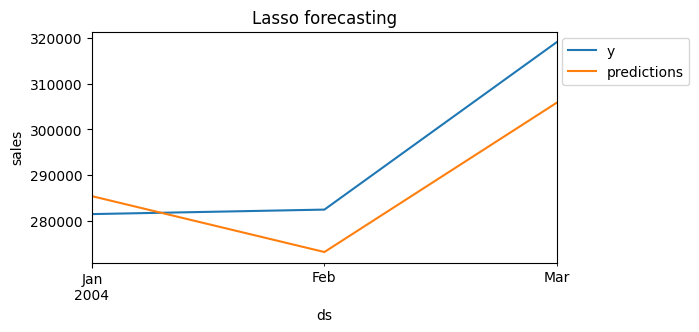

In [21]:
# prepare for plotting the first forecast

f = forecasts.iloc[0]
f.index = X_test.loc[end_train:].head(3).index

# Plot the forecast vs the actual

fig, ax = plt.subplots(figsize=(6, 3))
X_test.loc[end_train:].head(3).plot(ax=ax, label="train")
f.plot(ax=ax, label="predictions")
plt.ylabel("sales")
plt.title("Lasso forecasting")
ax.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

## Determine the RMSE

Pick the first row of predictions and calculate the RMSE

In [22]:
# Prediction error

error_rmse = root_mean_squared_error(
    y_true=X_test.loc[end_train:].head(3),
    y_pred=f,
)

print(f"Test error (rmse): {error_rmse}")

Test error (rmse): 9605.480832995758


## Forecast next 3 months of sales

Predict the first 3 months of sales right after the end of the test set.

That is, starting on `2005-02-02`.

In [23]:
# last point available in the test set

X_test.tail(1)

,y
ds,
2005-02-01,295062


In [24]:
# We need 12 points prior to the first point
# in the horizon

begin_test = "2004-02-03"
past_data = df.loc[begin_test:]

# we need to add to the dataset, the first
# point in the horizon

past_data.loc["2005-02-02 00:00:00"] = np.nan

past_data.index = pd.to_datetime(past_data.index)

past_data.shape

/var/folders/4h/md5_4rh50djgy5kphl9rzzy00000gn/T/ipykernel_20504/1572887211.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_data.loc["2005-02-02 00:00:00"] = np.nan


(13, 1)

In [25]:
past_data.head(2)

,y
ds,
2004-03-01,319077.0
2004-04-01,315191.0


In [26]:
past_data.tail(3)

,y
ds,
2005-01-01,293261.0
2005-02-01,295062.0
2005-02-02,NaN


In [27]:
# And now we forecast the 24 next hours.

pipe.predict(past_data)

array([[331802.84964425, 327690.27366618, 344365.54435326]])

You are done!! Congrats!!